In [39]:

from keras.layers import Input,Dense
from keras.models import Model
import matplotlib.image as mpimg
import numpy as np
import keras
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [32]:
%%time
import os
for dirPath, dirNames, fileNames in os.walk("figure"):
    pass
data=[]
for name in fileNames:
    path='figure/'+name
    img=mpimg.imread(path)
    #data.append(img[6:34,6:34,0:4])
    data.append(img[4:36,4:36,0:4])
data=np.array(data)

CPU times: user 194 ms, sys: 21.2 ms, total: 215 ms
Wall time: 215 ms


In [36]:
# changeList=[]
# for n in range(data.shape[0]):
#     if data[n].mean()<0.6:
#         changeList.append(n)
for i in range(data.shape[0]):
    bg=1-data[i,:,:,3]
    data[i,:,:,0]=bg+data[i,:,:,0]
    data[i,:,:,1]=bg+data[i,:,:,1]
    data[i,:,:,2]=bg+data[i,:,:,2]
    data[i,:,:,:][data[i,:,:,:]>1]=1

In [40]:
x_train=data[:-3]
x_test=data[-3:]

x_train=x_train.reshape(len(x_train),32,32,4)
x_test=x_test.reshape(len(x_test),32,32,4)

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Layer, Lambda, Flatten,Conv2DTranspose
from keras.models import Model
from keras import backend as K

input_img=Input(shape=(32,32,4))

conv1=Conv2D(32,(2,2),activation='relu',padding='same',strides=1)(input_img)
#maxpool1=MaxPooling2D((2,2),padding='same')(conv1)
conv2=Conv2D(32,(2,2),activation='relu',padding='same',strides=1)(conv1)
#maxpool2=MaxPooling2D((2,2),padding='same')(conv2)
conv3=Conv2D(32,(2,2),activation='relu',padding='same',strides=1)(conv2)
maxpool3=MaxPooling2D((2,2),padding='same')(conv3)
flat=Flatten()(maxpool3)
dense1=Dense(16*16)(flat)
dense2=Dense(16*8)(dense1)
z_mean=Dense(32)(dense2)
z_log_var=Dense(32)(dense2)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 1), mean=0.,
                              stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon
z = Lambda(sampling)([z_mean, z_log_var])
encoder=Model(input_img,z)

decoder_input=Input(shape=(32,))
dec_dense1=Dense(16*8)
dec_dense2=Dense(16*16*32)
dec_reshape=Reshape((16,16,32))
dec_conv1=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=1)
#dec_ups1=UpSampling2D((2,2))
dec_conv2=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=1)
#dec_ups2=UpSampling2D((2,2))
dec_conv3=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=1)
dec_ups3=UpSampling2D((2,2))
dec_conv4=Conv2D(4,(3,3),activation='sigmoid',padding='same',strides=1)

x=dec_dense1(z)
x=dec_dense2(x)
x=dec_reshape(x)
x=dec_conv1(x)
#x=dec_ups1(x)
x=dec_conv2(x)
#x=dec_ups2(x)
x=dec_conv3(x)
x=dec_ups3(x)
x=dec_conv4(x)

decoder=dec_dense1(decoder_input)
decoder=dec_dense2(decoder)
decoder=dec_reshape(decoder)
decoder=dec_conv1(decoder)
#decoder=dec_ups1(decoder)
decoder=dec_conv2(decoder)
#decoder=dec_ups2(decoder)
decoder=dec_conv3(decoder)
decoder=dec_ups3(decoder)
decoder=dec_conv4(decoder)

decoder=Model(decoder_input,decoder)


from keras import metrics
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True

        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, input_img, x):
        input_img=Flatten()(input_img)
        x=Flatten()(x)
        xent_loss = 32 *32* (metrics.binary_crossentropy((input_img), (x)))
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=1)
        return K.sum(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([input_img, x])
vae = Model(input_img, y)
vae.compile(optimizer='RMSprop', loss=None)
vae.summary()
# from keras.models import model_from_json
# vae.load_weights('./vae2_weight.h5')






__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4128        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   4128        conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


In [53]:
vae.compile(optimizer='Adam', loss=None)
vae.fit(x=x_train,shuffle=True,epochs=10,batch_size=32)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  """Entry point for launching an IPython kernel.


Epoch 1/10
789/789 [==============================] - 6s 7ms/step - loss: 4316.8427
Epoch 2/10
789/789 [==============================] - 5s 7ms/step - loss: 4317.5228
Epoch 3/10
789/789 [==============================] - 5s 6ms/step - loss: 4271.1507
Epoch 4/10
789/789 [==============================] - 5s 7ms/step - loss: 4241.3517
Epoch 5/10
789/789 [==============================] - 5s 7ms/step - loss: 4221.5268
Epoch 6/10
789/789 [==============================] - 5s 7ms/step - loss: 4209.1513
Epoch 7/10
789/789 [==============================] - 5s 7ms/step - loss: 4192.8074
Epoch 8/10
789/789 [==============================] - 5s 7ms/step - loss: 4192.9532
Epoch 9/10
789/789 [==============================] - 5s 7ms/step - loss: 4188.9913
Epoch 10/10
789/789 [==============================] - 5s 7ms/step - loss: 4195.4899


In [52]:
import json
from keras.applications import imagenet_utils
vae.save_weights('./vae_modImg_weight_500.h5')

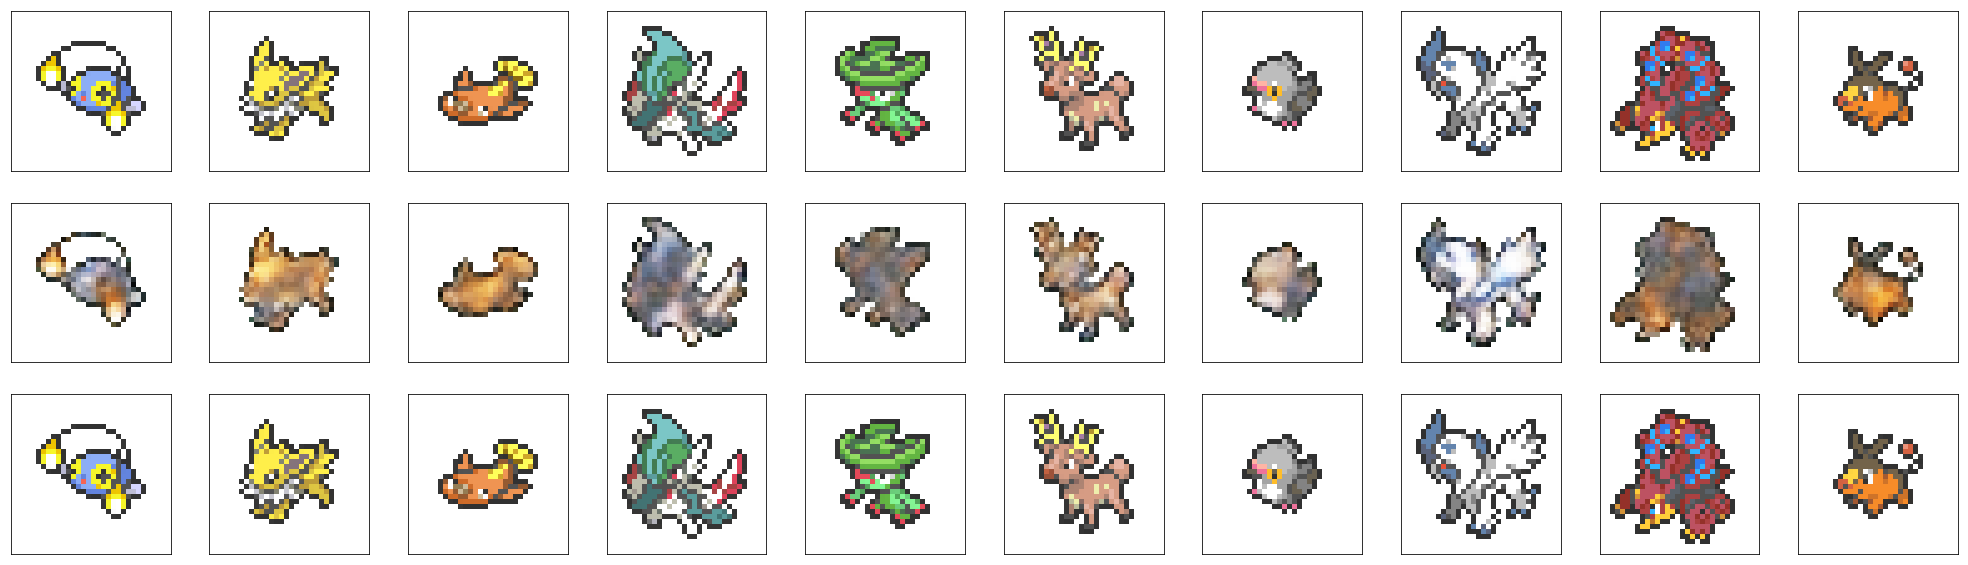

In [54]:

encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)
hello=vae.predict(x_train)
testImg = encoded_imgs[27]
n = 10  # how many digits we will display
plt.figure(figsize=(35, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    imgplot = plt.imshow(x_train[20+i][:,:,])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    imgplot = plt.imshow(decoded_imgs[20+i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    imgplot = plt.imshow(hello[20+i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# plt.savefig('training_result.png')
plt.show()



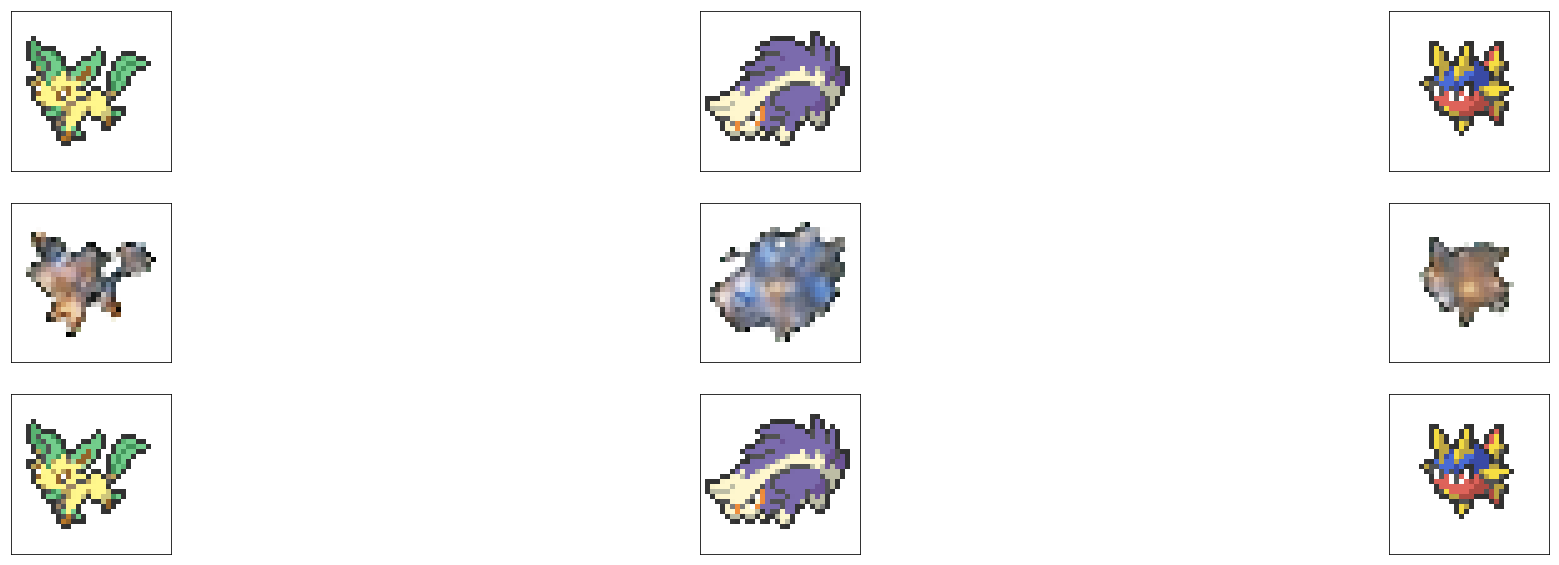

In [55]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
hello=vae.predict(x_test)
n = 3  # how many digits we will display
plt.figure(figsize=(35, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    imgplot = plt.imshow(x_test[0+i][:,:,])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    imgplot = plt.imshow(decoded_imgs[0+i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    imgplot = plt.imshow(hello[0+i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# plt.savefig('test_result.png')
plt.show()

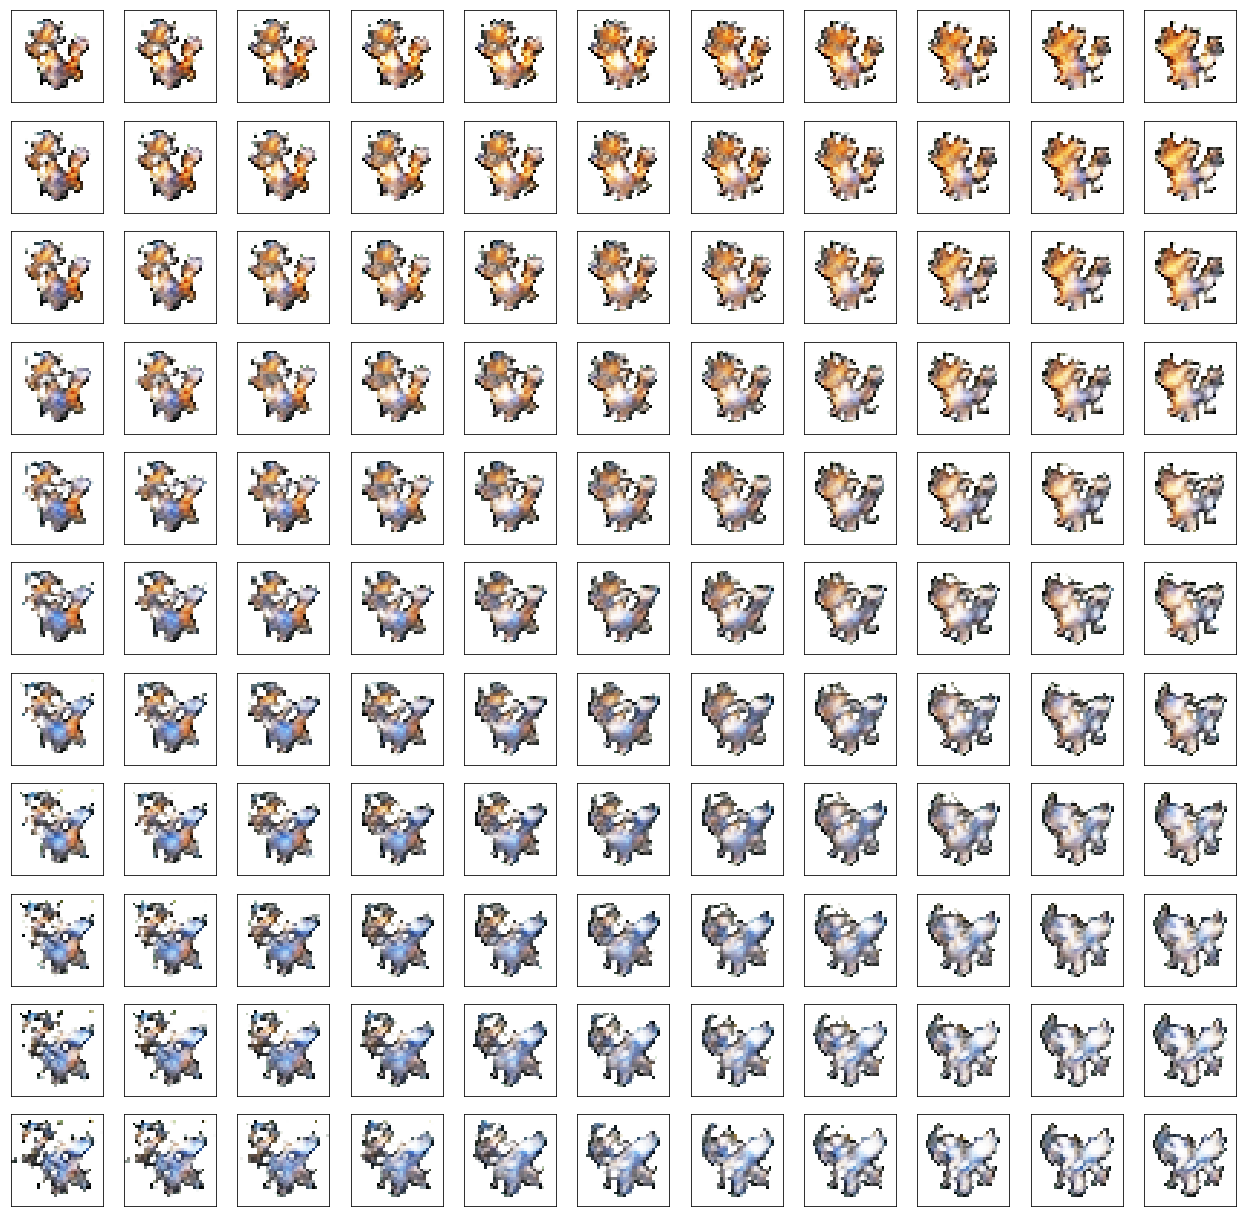

In [57]:
import random
base_img=testImg
grid=[-8+0.8*i for i in range(11)]
'''for i in range(30):
    base_img[2+i]=random.random()*2-1'''
#base_img[2:]=1
n = 11  # how many digits we will display
plt.figure(figsize=(22, 22))
for i in range(11):
    for j in range(11):
    # display original
        ax = plt.subplot(11, n, 11*i +j+ 1)
        target_img=base_img.copy()
        target_img[0]+=grid[i]
        target_img[1]+=grid[j]
        result=decoder.predict(target_img.reshape((1,32)))
        result=result.reshape((32,32,4))
        imgplot = plt.imshow(result)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
# plt.savefig('generate.png')
plt.show()

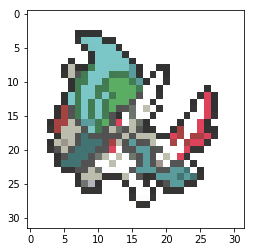

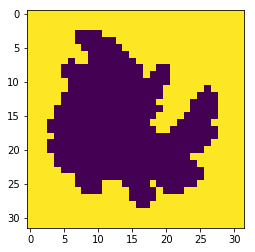

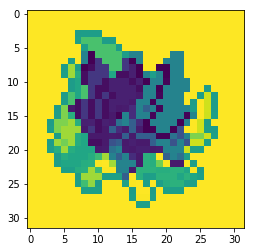

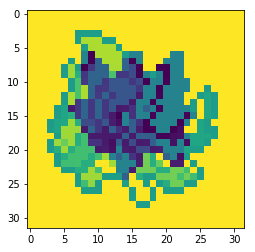

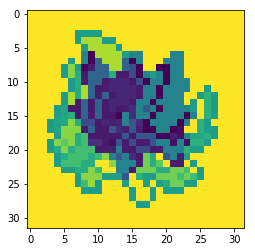

In [37]:
imgplot = plt.imshow(data[23,:,:])
plt.show()
plt.imshow(1-data[23,:,:,3])
plt.show()
plt.imshow(bg+data[23,:,:,0])
plt.show()
plt.imshow(bg+data[23,:,:,1])
plt.show()
plt.imshow(bg+data[23,:,:,2])  
plt.show()    